In [13]:
import numpy as np
from scipy import misc, ndimage
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import MaxoutDense
from keras.layers import Lambda
from keras.layers import LocallyConnected2D
from keras.layers import Dropout
from keras.layers import Merge
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import MaxoutDense
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K
K.set_image_dim_ordering('th')

%matplotlib inline

In [14]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# load data
(X_train_1, y_train_1), (X_test_1, y_test_1) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train_1 = X_train_1.reshape(X_train_1.shape[0], 1, 28, 28).astype('float32')
X_test_1 = X_test_1.reshape(X_test_1.shape[0], 1, 28, 28).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train_1 = X_train_1 / 255
X_test_1 = X_test_1 / 255

In [15]:
five_numbers = np.array([0, 3, 4, 5, 7])
mask_train = np.in1d(y_train_1, five_numbers)
mask_test  = np.in1d(y_test_1, five_numbers)
mask_train[:5]

array([ True,  True,  True, False, False], dtype=bool)

In [16]:
X_03457_train = X_train_1[mask_train]
y_03457_train = y_train_1[mask_train]

X_03457_test = X_test_1[mask_test]
y_03457_test = y_test_1[mask_test]

X_03457_train = X_03457_train.reshape((X_03457_train.shape[0], X_03457_train.shape[2], X_03457_train.shape[3]))
X_03457_test = X_03457_test.reshape((X_03457_test.shape[0], X_03457_test.shape[2], X_03457_test.shape[3]))

del X_train_1
del y_train_1
del X_test_1
del y_test_1

print(X_03457_train.shape)

(29582, 28, 28)


In [17]:
X_train_64 = np.zeros((len(X_03457_train), 64, 64))
X_test_64 = np.zeros((len(X_03457_test), 64, 64))

i = 0
while i < len(X_03457_train):
  X_train_64[i] = misc.imresize(X_03457_train[i].reshape((28, 28)), (64, 64))
  i += 1
  
j = 0
while j < len(X_03457_test):
  X_test_64[j] = misc.imresize(X_03457_test[j].reshape((28, 28)), (64, 64))
  j += 1
  
del X_03457_train
del X_03457_test

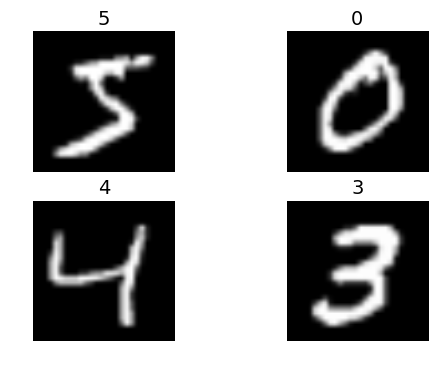

In [18]:
for i in range(4):
  plt.subplot(221 + i)
  plt.imshow(X_train_64[i].reshape(64, 64), cmap=plt.get_cmap('gray'))
  plt.title('{}'.format(y_03457_train[i]), fontsize=14)
  plt.axis('off')
  # show the plot


In [19]:
# one hot encode outputs
y_03457_train = np_utils.to_categorical(y_03457_train)[:, five_numbers]
y_03457_test = np_utils.to_categorical(y_03457_test)[:, five_numbers]

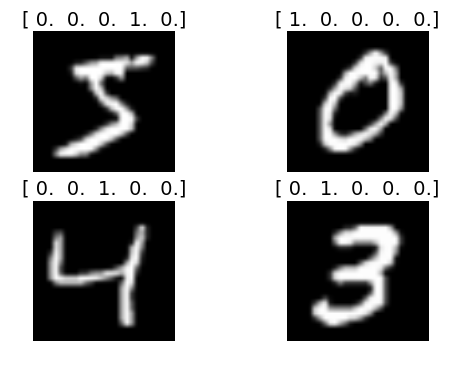

In [20]:
for i in range(4):
  plt.subplot(221 + i)
  plt.imshow(X_train_64[i].reshape((64, 64)), cmap=plt.get_cmap('gray'))
  plt.title('{}'.format(y_03457_train[i]), fontsize=14)
  plt.axis('off')
  # show the plot
# display()

In [21]:
def scale_and_shift(image):
  scale_factor = np.arange(0, 40, 2)
  scale = np.random.choice(scale_factor)
  incoming_dim = (64, 64)

  
  cropped_dim = (incoming_dim[0] - scale, incoming_dim[1] - scale)
  resized = misc.imresize(image.reshape(incoming_dim), cropped_dim)
  padded = np.pad(resized, scale/2, mode='constant')
  shift_x = np.random.randint(-scale/2 - 1, scale/2 + 1)
  shift_y = np.random.randint(-scale/2 - 1, scale/2 + 1)
  shifted = ndimage.interpolation.shift(padded, (shift_x, shift_y))
  
  return shifted.ravel()

def rotate(image):
  dim = (64, 64)
  rotation_factor = 15
  angle = np.random.randint(-rotation_factor - 1, rotation_factor + 1)
  rotated = ndimage.interpolation.rotate(image.reshape(dim), angle, reshape=False)
  return rotated.ravel()

In [22]:
X_03457_train = np.apply_along_axis(rotate, 1, 
                                    np.apply_along_axis(scale_and_shift, 1, X_train_64.reshape((-1, 4096))))

X_03457_test = np.apply_along_axis(rotate, 1, 
                                   np.apply_along_axis(scale_and_shift, 1, X_test_64.reshape((-1, 4096))))

del X_train_64
del X_test_64

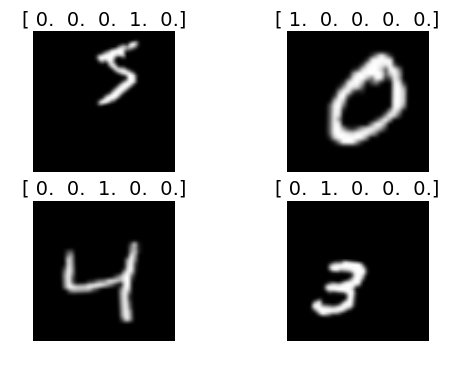

In [23]:
j=1
for i in range(4):
  plt.subplot(221 + i)
  plt.imshow((X_03457_train[i*j].reshape((64, 64))), cmap=plt.get_cmap('gray'))
  plt.title('{}'.format(y_03457_train[i*j]), fontsize=14)
  plt.axis('off')
  # show the plot
# display()

In [24]:
joined_train = np.hstack((X_03457_train, y_03457_train))
joined_test = np.hstack((X_03457_test, y_03457_test))

iterations = 4
data_train = np.copy(joined_train)
data_test = np.copy(joined_test)

for i in range(iterations): 
  np.random.shuffle(joined_train)
  np.random.shuffle(joined_test)
  data_train = np.vstack((data_train, joined_train))
  data_test = np.vstack((data_test, joined_test))

print(data_train.shape)
print(data_test.shape)


del X_03457_train
del y_03457_train

del X_03457_test
del y_03457_test

del joined_train
del joined_test


(147910, 4101)
(24460, 4101)


In [25]:
def make_3_digits(data):
  X = data[:, :4096]
  y = data[:, 4096:]
  
  i = 0
  N = X.shape[0] - 3
  num_features = 3 * X.shape[1]
  num_classes  = y.shape[1]

  X_3 = np.zeros((N, num_features))
  y_3 = np.zeros((N, 3, num_classes ))
  
  while i < N:
      num1 = X[i].reshape((64, 64))
      num2 = X[i+1].reshape((64, 64))
      num3 = X[i+2].reshape((64, 64))
      num123 = np.hstack((num1, num2, num3))

      label_1 = y[i] 
      label_2 = y[i + 1]
      label_3 = y[i + 2]
      label_123 = np.vstack((label_1, label_2, label_3))
      
      X_3[i] = num123.ravel()      
      y_3[i] = label_123
      
      i+=1
      
  return X_3, y_3



In [26]:
X_train_3, y_train_3 = make_3_digits(data_train)
X_test_3, y_test_3 = make_3_digits(data_test)

print(X_train_3.shape)
print(y_train_3.shape)

print('\n')

print(X_test_3.shape)
print(y_test_3.shape)

del data_train
del data_test

(147907, 12288)
(147907, 3, 5)


(24457, 12288)
(24457, 3, 5)


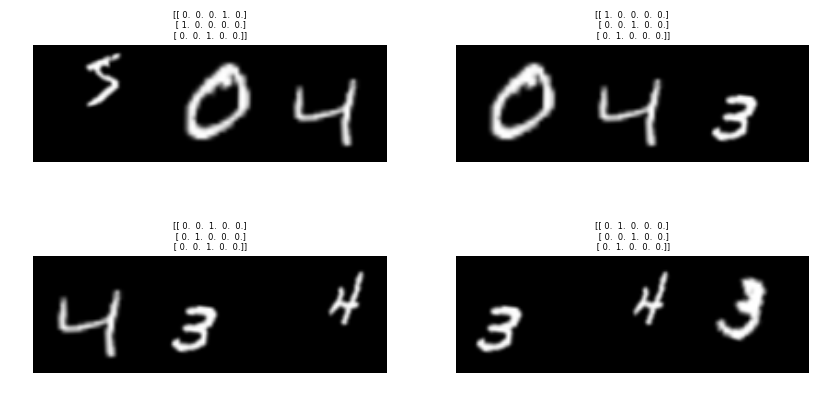

In [27]:
figure, axes = plt.subplots(2, 2, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(X_train_3[i].reshape(64, 192), cmap=plt.get_cmap('gray'))
  ax.set_title('{}'.format(y_train_3[i]), fontsize=6)
  ax.set_axis_off()
  # show the plot
# display(figure)

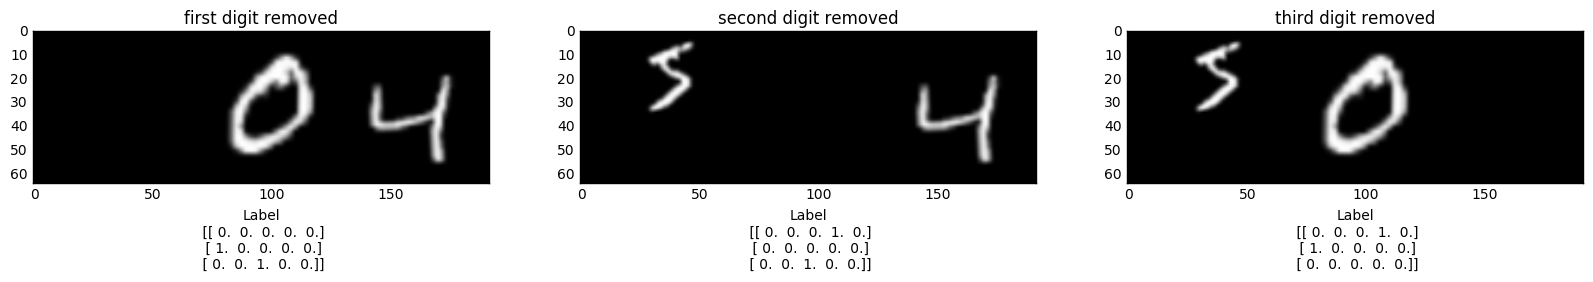

In [28]:
def remove_digit(digit, three_digit):
    two_digit = np.copy(three_digit)
    two_digit.reshape(64, 64*3)[:, (digit * 64) : ((digit + 1) * 64)] = 0
    return two_digit.ravel()

def revise_label(digit, label):
    label_copy = np.copy(label)
    label_copy[digit] = 0
    return label_copy
    

remove_key = {0:'first', 1:'second', 2:'third'}

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for digit, ax in zip(np.arange(3), axes):
    new_digits = remove_digit(digit, X_train_3[0])    
    new_label = revise_label(digit, y_train_3[0])
    
    ax.imshow(new_digits.reshape(64, 64*3), cmap=plt.get_cmap('gray'))
    ax.set_title("{} digit removed".format(remove_key[digit]))
    ax.set_xlabel('Label\n {}'.format(new_label))
# display(fig)    

In [29]:
def insert_spaces(X, y, p=0.5):
  N = X.shape[0]
  sample_size = int(N * p)
  space_idx = np.random.RandomState(1234).choice(np.arange(N), size=sample_size, replace=False)
  
  for i in space_idx:
    num_digits_to_remove = np.random.randint(1, 3)
    digit_places = [0, 1, 2]  
    j = 0
    while j < num_digits_to_remove:
        digit_to_remove = np.random.choice(digit_places)
        X[i] = remove_digit(digit_to_remove, X[i])
        y[i] = revise_label(digit_to_remove, y[i])
        digit_places.remove(digit_to_remove)
        j += 1
        
  return X, y

In [30]:
X_train_3_space, y_train_3_space = insert_spaces(X_train_3, y_train_3)
X_test_3_space, y_test_3_space = insert_spaces(X_test_3, y_test_3)

del X_train_3
del y_train_3
del X_test_3
del y_test_3

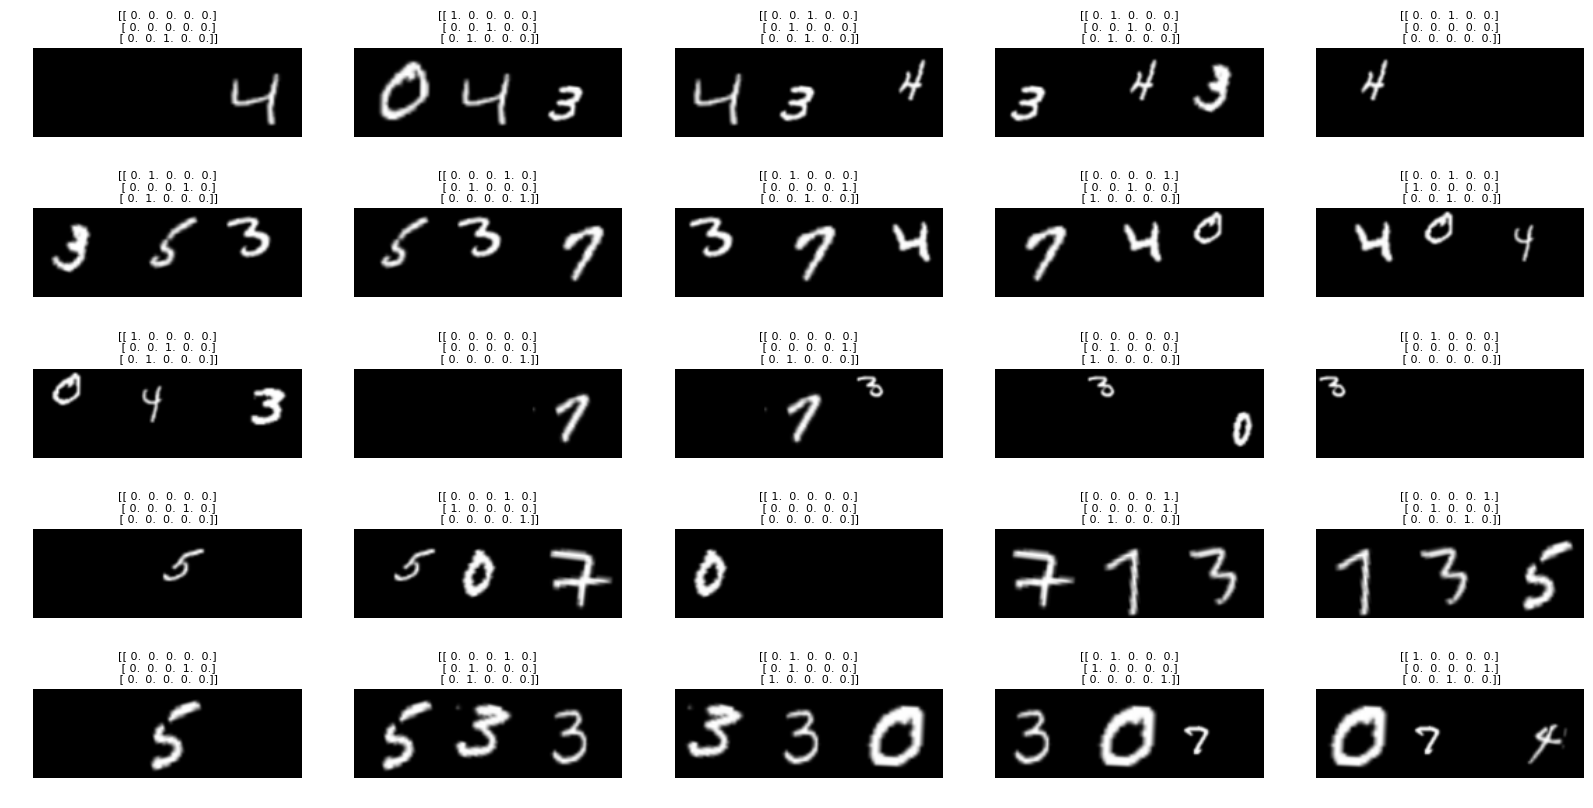

In [31]:
fig, axes = plt.subplots(5, 5, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_train_3_space[i].reshape(64, 64*3), cmap=plt.get_cmap('gray'))
    ax.set_title("{}".format(y_train_3_space[i]), fontsize=8)
    ax.set_axis_off()
# display(fig)

In [32]:
# Prepare inputs for Keras
X_train = X_train_3_space.reshape(X_train_3_space.shape[0], 1, 64, 192)
X_test = X_test_3_space.reshape(X_test_3_space.shape[0], 1, 64, 192)

y_train = y_train_3_space
y_test = y_test_3_space

del X_train_3_space
del X_test_3_space

del y_train_3_space
del y_test_3_space

In [33]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)
num_classes = y_train.shape[2]

In [34]:
ksdjklfdjlsk

NameError: name 'ksdjklfdjlsk' is not defined

In [ ]:
model = Sequential()
# input: 100x100 images with 3 channels -> (3, 100, 100) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(1, 64, 192)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.summary()

In [ ]:
def larger_model():
    # create model
    left = Sequential()
    # input: 100x100 images with 3 channels -> (3, 100, 100) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    left.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(1, 64, 64)))
    left.add(Activation('relu'))
    left.add(Convolution2D(32, 3, 3))
    left.add(Activation('relu'))
    left.add(MaxPooling2D(pool_size=(2, 2)))
    left.add(Dropout(0.25))

    left.add(Convolution2D(64, 3, 3, border_mode='valid'))
    left.add(Activation('relu'))
    left.add(Convolution2D(64, 3, 3))
    left.add(Activation('relu'))
    left.add(MaxPooling2D(pool_size=(2, 2)))
    left.add(Dropout(0.25))

    left.add(Flatten())
    # Note: Keras does automatic shape inference.
    left.add(Dense(256))
    left.add(Activation('relu'))
    left.add(Dropout(0.5))


#########################################################  
    middle = Sequential()
    # input: 100x100 images with 3 channels -> (3, 100, 100) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    middle.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(1, 64, 64)))
    middle.add(Activation('relu'))
    middle.add(Convolution2D(32, 3, 3))
    middle.add(Activation('relu'))
    middle.add(MaxPooling2D(pool_size=(2, 2)))
    middle.add(Dropout(0.25))

    middle.add(Convolution2D(64, 3, 3, border_mode='valid'))
    middle.add(Activation('relu'))
    middle.add(Convolution2D(64, 3, 3))
    middle.add(Activation('relu'))
    middle.add(MaxPooling2D(pool_size=(2, 2)))
    middle.add(Dropout(0.25))


    middle.add(Flatten())
    # Note: Keras does automatic shape inference.
    middle.add(Dense(256))
    middle.add(Activation('relu'))
    middle.add(Dropout(0.5))

#################################################
    right = Sequential()
    # input: 100x100 images with 3 channels -> (3, 100, 100) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    right.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(1, 64, 64)))
    right.add(Activation('relu'))
    right.add(Convolution2D(32, 3, 3))
    right.add(Activation('relu'))
    right.add(MaxPooling2D(pool_size=(2, 2)))
    right.add(Dropout(0.25))

    right.add(Convolution2D(64, 3, 3, border_mode='valid'))
    right.add(Activation('relu'))
    right.add(Convolution2D(64, 3, 3))
    right.add(Activation('relu'))
    right.add(MaxPooling2D(pool_size=(2, 2)))
    right.add(Dropout(0.25))


    right.add(Flatten())
    # Note: Keras does automatic shape inference.
    right.add(Dense(256))
    right.add(Activation('relu'))
    right.add(Dropout(0.5))


########################################################

    merged = Merge([left, middle, right], mode='concat')
    model = Sequential()
    model.add(merged)
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    return model

In [ ]:
# # build the model
# model = larger_model()
# # Fit the model
# model.fit(X, np.random.rand(400, 10),
#           validation_data=(X, np.random.rand(400,10)), nb_epoch=10, batch_size=200, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X, np.random.rand(400,10), verbose=0)
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# build the model
model = larger_model()
# Fit the model
model.fit([A, B, C], y)
# Final evaluation of the model
# scores = model.evaluate(X, np.random.rand(400,10), verbose=0)
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
print('done')

In [ ]:
A = np.random.rand(400, 1, 64, 64)
B = np.random.rand(400, 1, 64, 64)
C = np.random.rand(400, 1, 64, 64)
y = np.random.rand(400, 3, 5)